# Analyze Robustness to Expression Noise

Author: Jacob Parres-Gold (jacobparresgold@gmail.com)

Last Revised: 20231019

This notebook will simulate various networks (one for each unique function) under random perturbations of monomer expression levels (total abundances). We will simulate 50 perturbations each for two scenarios: entirely "intrinsic" noise (all monomers perturbed independently) and entirely "extrinsic" noise (all monomers perturbed by the same fold change). The perturbations will be selected from a gamma distribution (the continuous analog of the negative binomial distribution), which is the steady-state distribution of mRNA counts produced by [bursty transcription](https://biocircuits.github.io/chapters/16_bursty.html).


We will use a noise [coefficient of variation](https://biocircuits.github.io/chapters/15_noise.html) of 0.4 for independent noise and 0.6 for concerted noise, as per [Quarton et al. 2020](https://doi.org/10.1093/nar/gkaa668). For information on how the gamma distribution parameters were determined from this noise level, see the Methods, [Antebi et al. 2017](https://doi.org/10.1016/j.cell.2017.08.015), and the [Distribution Explorer](https://distribution-explorer.github.io/continuous/gamma.html).


In [31]:
import importlib
import itertools
import math
import numpy as np
import os
import pandas as pd
import pathlib
import scipy.stats
import sys
import time

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import seaborn as sns

# EQTK to calculate equilibrium concentrations - install instructions here https://eqtk.github.io/getting_started/eqtk_installation.html
import eqtk

# Ray for parallelization - install instructions here https://docs.ray.io/en/latest/ray-overview/installation.html
import ray

# Networkx for graphs - install instructions here https://networkx.org/documentation/stable/install.html
import networkx as nx

In [3]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)
import dimer_network_utilities
from dimer_network_utilities import *

In [3]:
# Initialize ray
_ = ray.init(ignore_reinit_error=True)

In [ ]:
# To shut down ray:
ray.shutdown()

In [4]:
# Define directory to save to
out_dir = str(pathlib.Path('C:\\Users','jacob','Downloads'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [5]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 72.0,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [6]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

Package versions:
python=3.8.13
eqtk=0.1.3
matplotlib=3.7.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


## Functions for Simulations

In [9]:
def run_eqtk(N, C0, params, acc_monomer_ind):
    """
    Run eqtk.solve given the input stoichiometry matrix, initial concentrations, and parameters.

    See eqtk.solve documentation for more details on the syntax.
    (https://eqtk.github.io/user_guide/generated/highlevel/eqtk.solve.html)

    Parameters
    ----------
    N : Array-like, shape (num_rxns, num_species)
        Input stoichiometry matrix
    C0 : Array-like, shape (num_simulation_points, num_species)
        Initial concentrations of all species for each simulation point.
        Accessory monomer levels will be set based on params.
    params : List-like, len num_combos_with_replacement(m,2) + (m-1)
        Parameters including Kij values and accessory monomer levels
    acc_monomer_ind : int  
        Index of accessory monomers in species list
    
    Returns
    -------
    C: Array-like
        Equilibrium concentrations of all species
    """
    num_rxns = N.shape[0]
    # Extract Kij values
    K = params[:num_rxns]
    # Set accessory monomer levels
    C0[:,acc_monomer_ind] = params[num_rxns:]

    return eqtk.solve(c0=C0, N=N, K=K)

In [10]:
@ray.remote
def simulate_networks(m, num_inputs, param_sets, t = 12, input_lb = -3, input_ub = 3):
    """
    Run simulations for dimer networks, over a titration of concentrations for each input monomer. 
    When >1 input monomers are varied (e.g., a 2D matrix), the first monomer is sampled outermost, 
    while the second is sampled inner to that.
    
    Parameters
    ----------
    m : int. 
        Number of monomer species in the network.
    num_inputs: int
        Number of monomers to count as inputs (those titrated). 
        E.g., if num_inputs=2, the first two monomers will be treated as inputs.
    t : int. Default 12. 
        Number of values to titrate each input monomer species. 
        Values spaced evenly on a log10 scale
    input_lb : int. Default -3
        lower bound for titrating the input monomer species. Log10 scale
    input_ub : int. Default 3
        upper bound for titrating the input monomer species.Llog10 scale
    param_sets : Array-like, shape (num_sets, num_parameters)
        Parameter sets for simulating multiple dimerization networks.  
    Returns
    -------
    C0 : Array-like, shape (t, number of species)
        Initial concentration array used for eqtk.solve
    S_all : Array-like, shape (t, number of species, num_sets) 
        Equlibrium concentration of all species
        for all parameter sets and each input titration point.
        
    """
    # Create stoichiometry matrix 
    num_sets = param_sets.shape[0]
    N = make_nXn_stoich_matrix(m)
    num_rxns = N.shape[0]

    # Create initial concentration array
    M0_min = [input_lb]*num_inputs + [0] * (m-num_inputs) # Species concentrations at min of inputs
    M0_max = [input_ub]*num_inputs + [0] * (m-num_inputs) # Species concentrations at max of inputs
    num_conc = [t]*num_inputs + [1] * (m-num_inputs) # Number of concentrations to titrate for each species
    C0 = make_C0_grid(m, M0_min=M0_min, M0_max=M0_max, num_conc=num_conc) 
        
    acc_monomer_ind = np.arange(num_inputs,m) # Indices of accessory monomers
    S_all = np.zeros((C0.shape[0], C0.shape[1], num_sets))
    # For each parameter set, run eqtk.solve
    for pset_index, pset in enumerate(param_sets):
        S_all[:,:,pset_index] = run_eqtk(N, C0.copy(), pset, acc_monomer_ind)
    return C0,S_all  
                

In [ ]:
@ray.remote
def ray_digitize(S_all_filtered_processed,boundaries):
    return np.digitize(S_all_filtered_processed,boundaries)

In [ ]:
def calculate_unique_voxels(S_all_filtered_processed,boundaries,t,return_inverse=False,curves_per_chunk=5000):
    '''
    Given curves, group them into discretized "voxels" by binning the output at each input point.
    
    Parameters:
    ----------
    S_all_filtered_processed: 2D array of shape (n_curves, t)
        Array of all responses
    boundaries: 1D array
        Array of boundaries at which to split output space.
    curves_per_chunk: Int
        Number of curves to consider at once.
    return_inverse: Bool
        Whether to return unique_inverse, a map of which curve went into which unique voxel.
        
    Returns:
    --------
    unique_voxels: 2D array of shape (n_unique_voxels, t)
        Array of all unique voxels found
    unique_inverse: 1D array of shape (n_curves,)
        Array describing, for each curve in the original dataset, which voxel in 
        unique_voxels it was assigned to.
    '''
    n_digitize_chunks = math.ceil(S_all_filtered_processed.shape[0]/curves_per_chunk)
    voxels = np.empty((S_all_filtered_processed.shape[0],t))
    digitize_futures = []
    for chunk in range(n_digitize_chunks):
        digitize_futures.append(ray_digitize.remote(S_all_filtered_processed[chunk*curves_per_chunk:(chunk+1)*curves_per_chunk,:],\
                                boundaries))
    for chunk in range(n_digitize_chunks):
        voxels[chunk*curves_per_chunk:(chunk+1)*curves_per_chunk,:] = ray.get(digitize_futures[chunk])
    return np.unique(voxels,axis=0,return_inverse=return_inverse)

## Perform Simulations

In [ ]:
out_dir = str(pathlib.Path('/','home','ubuntu','Data','20230420_analysis'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [ ]:
load_from_rawdata = str(pathlib.Path('/','home','ubuntu','Data/20221108_1input_randomParamset'))
load_from_analysis1 = str(pathlib.Path('/','home','ubuntu','Data/20221201_analysis'))
load_from_analysis2 = str(pathlib.Path('/','home','ubuntu','Data/20230207_analysis'))

In [ ]:
# Load, if necessary
S_all_filenames_by_m = np.load(str(pathlib.Path(load_from_analysis1,'S_all_filenames_by_m.npy')),allow_pickle=True)
all_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_from_analysis1,'all_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
unfiltered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_from_analysis1,'unfiltered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
nonzero_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_from_analysis1,'nonzero_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
filtered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_from_analysis1,'filtered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)

In [ ]:
num_inputs = 1
input_lb = -3 # Lower bound for log10 of input concentrations
input_ub = 3 # Upper bound for log10 of input concentrations
t = 30 # Number of input concentrations to simulate
max_curves_per_chunk_to_simulate=5000 # Maximum number of curves to simulate in a single "chunk"

In [ ]:
m_list = list(range(2,13)) # Network sizes to test

### Simulate Independent Noise

Each monomer will be perturbed independently

In [ ]:
independent_out_dir = str(pathlib.Path(out_dir,'independent_perturbation'))

if not os.path.isdir(independent_out_dir):
        os.mkdir(independent_out_dir)

In [ ]:
rng = np.random.default_rng()

num_A_sets = 50

# Gamma distribution parameters
independent_noise = 0.4

independent_shape = 1/(independent_noise**2)
independent_scale = independent_noise**2

In [ ]:
# Define voxels
t_voxels = 6
boundaries = np.logspace(input_lb,input_ub,t_voxels+1,endpoint=True)[1:-1]

In [16]:
def calculate_RMSD(points1,points2):
    if len(points1)!=len(points2):
        print("Two datasets must be of same length.")
        return
    square_differences = (points1-points2)**2
    return np.sqrt(np.sum(square_differences)/len(square_differences))

In [ ]:
def calculate_mean_abs_difference(points1,points2):
    if len(points1)!=len(points2):
        print("Two datasets must be of same length.")
        return
    abs_differences = np.abs(points1-points2)
    return np.mean(abs_differences)

In [ ]:
for m in m_list:
    m_i = m_list.index(m)
    specific_out_dir = str(pathlib.Path(independent_out_dir,f'{m}M'))
    if not os.path.isdir(specific_out_dir):
        os.mkdir(specific_out_dir)
    curves_by_voxel =  np.load(str(pathlib.Path(load_from_analysis2,f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    num_unique_voxels = len(curves_by_voxel)
    param_sets = np.load(str(pathlib.Path(load_from_rawdata,f'{m}M_1',f'K_A_param_sets.npy')),allow_pickle=True)

    # For each unique function (voxel), randomly choose a representative curve
    # Note that these indices refer to the filtered responses
    representative_curve_ids = np.array([rng.choice(x) for x in curves_by_voxel])

    # Initialize array
    unfiltered_curve_ids = np.full((len(representative_curve_ids),),-1)

    # Now go through the past data and extract the parameter sets that gave rise to the chosen ("representative") responses
    S_all_filenames = S_all_filenames_by_m[m_i]
    num_S_all_chunks = len(S_all_filenames)
    # Iterate over chunks in which different response files were saved
    for S_all_chunk in range(num_S_all_chunks):
        # Load univ_filter_map, which maps unfiltered response IDs to in-chunk filtered response IDs (i.e., starts at 0 no matter which chunk you're in)
        univ_filter_map_filename = str(pathlib.Path(load_from_rawdata,f'{m}M_1',f'univ_filter_map_{S_all_chunk}.npy'))
        univ_filter_map = np.load(univ_filter_map_filename,allow_pickle=True)

        # Convert in-chunk IDs to ids across all chunks
        unfiltered_ids_in_chunk = univ_filter_map[:,0] + np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])
        filtered_ids_in_chunk = univ_filter_map[:,1] + np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])

        # Identify which of the "representative" responses came from this chunk
        representative_filtered_ids_in_chunk = representative_curve_ids[np.where(np.isin(representative_curve_ids,filtered_ids_in_chunk))[0]]
        representative_unfiltered_ids_in_chunk = unfiltered_ids_in_chunk[np.where(np.isin(filtered_ids_in_chunk,representative_filtered_ids_in_chunk))[0]]

        # Use the above info to identify the unfiltered IDs of the representative responses, fill array values
        unfiltered_curve_ids[np.where(np.isin(representative_curve_ids,filtered_ids_in_chunk))[0]] = \
                representative_unfiltered_ids_in_chunk

    # Now that we know the unfiltered IDs, we can easily calculate which parameter set and dimer each came from
    selected_param_set_ids = np.array([x//num_combos_with_replacement(m,r=2) for x in unfiltered_curve_ids])
    selected_dimer_ids = np.array([x%num_combos_with_replacement(m,r=2) for x in unfiltered_curve_ids])

    # Extract the parameter sets of interest
    selected_param_sets = param_sets[selected_param_set_ids,:]

    # Now we will perturb all but the original param set
    selected_perturbed_param_sets = np.repeat(selected_param_sets,num_A_sets,axis=0)
    for original_id in range(num_unique_voxels):
        param_set_ids_to_perturb = np.array(list(range((original_id*num_A_sets)+1,(original_id+1)*num_A_sets)))
        # Multiply the original accessory expression vals by randomly chosen factors
        selected_perturbed_param_sets[param_set_ids_to_perturb,-(m-1):] = np.multiply(selected_param_sets[original_id,-(m-1):],\
                                                                          rng.gamma(shape=independent_shape,scale=independent_scale,size=(num_A_sets-1,m-1)))

    np.save(str(pathlib.Path(specific_out_dir,f'selected_param_set_ids.npy')), selected_param_set_ids)
    np.save(str(pathlib.Path(specific_out_dir,f'selected_dimer_ids.npy')), selected_dimer_ids)
    np.save(str(pathlib.Path(specific_out_dir,f'selected_perturbed_param_sets.npy')), selected_perturbed_param_sets)

    # Simulate
    # We chunk the simulations into smaller bits for parallelization with Ray
    print(f"Simulating m={m}")
    num_sim_chunks = math.ceil(selected_perturbed_param_sets.shape[0]/max_curves_per_chunk_to_simulate)
    S_all = np.zeros((t,m+num_combos_with_replacement(m,r=2),selected_perturbed_param_sets.shape[0]))
    sim_futures = []
    for chunk in range(num_sim_chunks):
        if chunk==num_sim_chunks:
            param_sets_temp = selected_perturbed_param_sets[(chunk*max_curves_per_chunk_to_simulate):]
        else:
            param_sets_temp = selected_perturbed_param_sets[(chunk*max_curves_per_chunk_to_simulate):((chunk+1)*max_curves_per_chunk_to_simulate)]
        sim_futures.append(simulate_networks.remote(m = m, num_inputs = num_inputs, t = t, param_sets=param_sets_temp, input_lb = input_lb, \
                                input_ub = input_ub))
    for chunk,future in zip(range(num_sim_chunks),sim_futures):
        _, S_all_temp = ray.get(future)
        if chunk==num_sim_chunks:
            S_all[:,:,(chunk*max_curves_per_chunk_to_simulate):] = S_all_temp
        else:
            S_all[:,:,(chunk*max_curves_per_chunk_to_simulate):((chunk+1)*max_curves_per_chunk_to_simulate)] = S_all_temp

    # We only care about the responses from our dimers of interest - so we'll extract those responses
    dimers_per_param_set = num_combos_with_replacement(m,2)
    S_all_reshaped = S_all[:,m:,:].reshape((t,-1),order='F').T # Exclude all monomers
    response_ids_of_interest = np.add(np.arange(0,num_unique_voxels*num_A_sets*dimers_per_param_set,dimers_per_param_set),\
                                      np.repeat(selected_dimer_ids,num_A_sets))
    perturbed_responses = S_all_reshaped[response_ids_of_interest,:]
    # Round concentrations that are too small to be relevant
    perturbed_responses[np.where(perturbed_responses<10**input_lb)] = 10**input_lb
    np.save(str(pathlib.Path(specific_out_dir,f'perturbed_responses.npy')), perturbed_responses)

    # For each unique function we perturbed, we will calculate curve distances from the original in log space
    rmsds_by_function = []
    mean_abs_diff_by_function = []
    for function_id in range(num_unique_voxels):
        original = np.log10(perturbed_responses[function_id*num_A_sets])
        all_perturbed = np.log10(perturbed_responses[(function_id*num_A_sets)+1:(function_id+1)*num_A_sets])
        rmsds_by_function.append([calculate_RMSD(original,perturbed) for perturbed in all_perturbed])
        mean_abs_diff_by_function.append([calculate_mean_abs_difference(original,perturbed) for perturbed in all_perturbed])
    
    chebyshev_dists_by_function = [scipy.spatial.distance.cdist(np.log10(np.expand_dims(perturbed_responses[function_id*num_A_sets],axis=0)),\
                                                                np.log10(perturbed_responses[(function_id*num_A_sets)+1:(function_id+1)*num_A_sets]),\
                                                                metric='chebyshev')[0,:] for function_id in range(num_unique_voxels)]
    
    np.save(str(pathlib.Path(specific_out_dir,f'rmsds_by_function.npy')), rmsds_by_function)
    np.save(str(pathlib.Path(specific_out_dir,f'mean_abs_diff_by_function.npy')), mean_abs_diff_by_function)
    np.save(str(pathlib.Path(specific_out_dir,f'chebyshev_dists_by_function.npy')), chebyshev_dists_by_function)
    
    # Categorize responses into unique functions (voxels)
    perturbed_responses_averaged = np.zeros((perturbed_responses.shape[0],t_voxels))
    points_to_average = int(t//t_voxels)
    for input1 in range(t_voxels):
        perturbed_responses_averaged[:,input1] = 10**np.mean(np.log10(perturbed_responses[:,\
                                                                        (input1*points_to_average):(input1*points_to_average)+points_to_average]),axis=1)
    perturbed_voxels_by_original_voxel = []
    perturbed_curves_by_voxel_by_original_voxel = []
    perturbed_voxel_averages_by_original_voxel = []
    for original_voxel in range(num_unique_voxels):
        perturbed_responses_averaged_this_voxel = perturbed_responses_averaged[original_voxel*num_A_sets:(original_voxel+1)*num_A_sets,:]
        unique_voxels,unique_inverse = calculate_unique_voxels(perturbed_responses_averaged_this_voxel,boundaries,t=t_voxels,return_inverse=True)
        perturbed_curves_by_voxel = []
        voxel_averages = np.zeros((unique_voxels.shape[0],t))
        for unique_voxel in range(unique_voxels.shape[0]):
            perturbed_curves_by_voxel.append(np.where(unique_inverse==unique_voxel)[0])
        for unique_voxel in range(unique_voxels.shape[0]):
            clustered_responses_temp = perturbed_responses[perturbed_curves_by_voxel[unique_voxel],:]
            # Take average in log space
            voxel_averages[unique_voxel,:] = np.expand_dims(10**np.mean(np.log10(clustered_responses_temp),axis=0),axis=0)
        # Add to lists
        perturbed_voxels_by_original_voxel.append(unique_voxels)
        perturbed_curves_by_voxel_by_original_voxel.append(perturbed_curves_by_voxel)
        perturbed_voxel_averages_by_original_voxel.append(voxel_averages)
    
    # Save
    np.save(str(pathlib.Path(specific_out_dir,f'perturbed_voxels_by_original_voxel.npy')),\
            np.array(perturbed_voxels_by_original_voxel,dtype='object'))
    np.save(str(pathlib.Path(specific_out_dir,f'perturbed_curves_by_voxel_by_original_voxel.npy')),\
            np.array(perturbed_curves_by_voxel_by_original_voxel,dtype='object'))
    np.save(str(pathlib.Path(specific_out_dir,f'perturbed_voxel_averages_by_original_voxel.npy')),\
            np.array(perturbed_voxel_averages_by_original_voxel,dtype='object'))

Simulating m=2
Simulating m=3
Simulating m=4
Simulating m=5
Simulating m=6
Simulating m=7
Simulating m=8
Simulating m=9
Simulating m=10


### Simulate Concerted Noise

Each monomer will be perturbed by the same fold change, but potentially with larger perturbations because the noise coefficient is larger.

In [ ]:
concerted_out_dir = str(pathlib.Path(out_dir,'concerted_perturbation'))

In [ ]:
rng = np.random.default_rng()

num_A_sets = 50

# Gamma distribution parameters
concerted_noise = 0.6

concerted_shape = 1/(concerted_noise**2)
concerted_scale = concerted_noise**2

In [ ]:
# Define voxels
t_voxels = 6 # Number of bins in input and output
boundaries = np.logspace(input_lb,input_ub,t_voxels+1,endpoint=True)[1:-1]

In [ ]:
def calculate_RMSD(points1,points2):
    if len(points1)!=len(points2):
        print("Two datasets must be of same length.")
        return
    square_differences = (points1-points2)**2
    return np.sqrt(np.sum(square_differences)/len(square_differences))

In [ ]:
def calculate_mean_abs_difference(points1,points2):
    if len(points1)!=len(points2):
        print("Two datasets must be of same length.")
        return
    abs_differences = np.abs(points1-points2)
    return np.mean(abs_differences)

In [ ]:
for m in m_list:
    m_i = m_list.index(m)
    specific_out_dir = str(pathlib.Path(concerted_out_dir,f'{m}M'))
    if not os.path.isdir(specific_out_dir):
        os.mkdir(specific_out_dir)
    curves_by_voxel =  np.load(str(pathlib.Path(load_from_analysis2,f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    num_unique_voxels = len(curves_by_voxel)
    param_sets = np.load(str(pathlib.Path(load_from_rawdata,f'{m}M_1',f'K_A_param_sets.npy')),allow_pickle=True)

    # For each unique function (voxel), randomly choose a representative curve
    # Note that these indices refer to the filtered responses
    representative_curve_ids = np.array([rng.choice(x) for x in curves_by_voxel])

    # Initialize array
    unfiltered_curve_ids = np.full((len(representative_curve_ids),),-1)

    # Now go through the past data and extract the parameter sets that gave rise to the chosen ("representative") responses
    S_all_filenames = S_all_filenames_by_m[m_i]
    num_S_all_chunks = len(S_all_filenames)
    # Iterate over chunks in which different response files were saved
    for S_all_chunk in range(num_S_all_chunks):
        # Load univ_filter_map, which maps unfiltered response IDs to in-chunk filtered response IDs (i.e., starts at 0 no matter which chunk you're in)
        univ_filter_map_filename = str(pathlib.Path(load_from_rawdata,f'{m}M_1',f'univ_filter_map_{S_all_chunk}.npy'))
        univ_filter_map = np.load(univ_filter_map_filename,allow_pickle=True)

        # Convert in-chunk IDs to ids across all chunks
        unfiltered_ids_in_chunk = univ_filter_map[:,0] + np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])
        filtered_ids_in_chunk = univ_filter_map[:,1] + np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])

        # Identify which of the "representative" responses came from this chunk
        representative_filtered_ids_in_chunk = representative_curve_ids[np.where(np.isin(representative_curve_ids,filtered_ids_in_chunk))[0]]
        representative_unfiltered_ids_in_chunk = unfiltered_ids_in_chunk[np.where(np.isin(filtered_ids_in_chunk,representative_filtered_ids_in_chunk))[0]]

        # Use the above info to identify the unfiltered IDs of the representative responses, fill array values
        unfiltered_curve_ids[np.where(np.isin(representative_curve_ids,filtered_ids_in_chunk))[0]] = \
                representative_unfiltered_ids_in_chunk

    # Now that we know the unfiltered IDs, we can easily calculate which parameter set and dimer each came from
    selected_param_set_ids = np.array([x//num_combos_with_replacement(m,r=2) for x in unfiltered_curve_ids])
    selected_dimer_ids = np.array([x%num_combos_with_replacement(m,r=2) for x in unfiltered_curve_ids])

    # Extract the parameter sets of interest
    selected_param_sets = param_sets[selected_param_set_ids,:]

    # Now we will perturb all but the original param set
    selected_perturbed_param_sets = np.repeat(selected_param_sets,num_A_sets,axis=0)
    for original_id in range(num_unique_voxels):
        param_set_ids_to_perturb = np.array(list(range((original_id*num_A_sets)+1,(original_id+1)*num_A_sets)))
        # Multiply the original accessory expression vals by the same randomly chosen factor
        concerted_perturb_factors = rng.gamma(shape=concerted_shape,scale=concerted_scale,size=(num_A_sets-1,1))
        selected_perturbed_param_sets[param_set_ids_to_perturb,-(m-1):] = np.multiply(selected_param_sets[original_id,-(m-1):],\
                                                                          np.tile(concerted_perturb_factors,reps=(1,m-1)))

    np.save(str(pathlib.Path(specific_out_dir,f'selected_param_set_ids.npy')), selected_param_set_ids)
    np.save(str(pathlib.Path(specific_out_dir,f'selected_dimer_ids.npy')), selected_dimer_ids)
    np.save(str(pathlib.Path(specific_out_dir,f'selected_perturbed_param_sets.npy')), selected_perturbed_param_sets)

    # Simulate
    # We chunk the simulations into smaller bits for parallelization with Ray
    print(f"Simulating m={m}")
    num_sim_chunks = math.ceil(selected_perturbed_param_sets.shape[0]/max_curves_per_chunk_to_simulate)
    S_all = np.zeros((t,m+num_combos_with_replacement(m,r=2),selected_perturbed_param_sets.shape[0]))
    sim_futures = []
    for chunk in range(num_sim_chunks):
        if chunk==num_sim_chunks:
            param_sets_temp = selected_perturbed_param_sets[(chunk*max_curves_per_chunk_to_simulate):]
        else:
            param_sets_temp = selected_perturbed_param_sets[(chunk*max_curves_per_chunk_to_simulate):((chunk+1)*max_curves_per_chunk_to_simulate)]
        sim_futures.append(simulate_networks.remote(m = m, num_inputs = num_inputs, t = t, param_sets=param_sets_temp, input_lb = input_lb, \
                                input_ub = input_ub))
    for chunk,future in zip(range(num_sim_chunks),sim_futures):
        _, S_all_temp = ray.get(future)
        if chunk==num_sim_chunks:
            S_all[:,:,(chunk*max_curves_per_chunk_to_simulate):] = S_all_temp
        else:
            S_all[:,:,(chunk*max_curves_per_chunk_to_simulate):((chunk+1)*max_curves_per_chunk_to_simulate)] = S_all_temp

    # We only care about the responses from our dimers of interest - so we'll extract those responses
    dimers_per_param_set = num_combos_with_replacement(m,2)
    S_all_reshaped = S_all[:,m:,:].reshape((t,-1),order='F').T # Exclude all monomers
    response_ids_of_interest = np.add(np.arange(0,num_unique_voxels*num_A_sets*dimers_per_param_set,dimers_per_param_set),\
                                      np.repeat(selected_dimer_ids,num_A_sets))
    perturbed_responses = S_all_reshaped[response_ids_of_interest,:]
    # Round concentrations that are too small to be relevant
    perturbed_responses[np.where(perturbed_responses<10**input_lb)] = 10**input_lb
    np.save(str(pathlib.Path(specific_out_dir,f'perturbed_responses.npy')), perturbed_responses)

    # For each unique function we perturbed, we will calculate curve distances from the original in log space
    rmsds_by_function = []
    mean_abs_diff_by_function = []
    for function_id in range(num_unique_voxels):
        original = np.log10(perturbed_responses[function_id*num_A_sets])
        all_perturbed = np.log10(perturbed_responses[(function_id*num_A_sets)+1:(function_id+1)*num_A_sets])
        rmsds_by_function.append([calculate_RMSD(original,perturbed) for perturbed in all_perturbed])
        mean_abs_diff_by_function.append([calculate_mean_abs_difference(original,perturbed) for perturbed in all_perturbed])
    
    chebyshev_dists_by_function = [scipy.spatial.distance.cdist(np.log10(np.expand_dims(perturbed_responses[function_id*num_A_sets],axis=0)),\
                                                                np.log10(perturbed_responses[(function_id*num_A_sets)+1:(function_id+1)*num_A_sets]),\
                                                                metric='chebyshev')[0,:] for function_id in range(num_unique_voxels)]
    
    np.save(str(pathlib.Path(specific_out_dir,f'rmsds_by_function.npy')), rmsds_by_function)
    np.save(str(pathlib.Path(specific_out_dir,f'mean_abs_diff_by_function.npy')), mean_abs_diff_by_function)
    np.save(str(pathlib.Path(specific_out_dir,f'chebyshev_dists_by_function.npy')), chebyshev_dists_by_function)
    
    # Categorize responses into unique functions (voxels)
    perturbed_responses_averaged = np.zeros((perturbed_responses.shape[0],t_voxels))
    points_to_average = int(t//t_voxels)
    for input1 in range(t_voxels):
        perturbed_responses_averaged[:,input1] = 10**np.mean(np.log10(perturbed_responses[:,\
                                                                        (input1*points_to_average):(input1*points_to_average)+points_to_average]),axis=1)
    perturbed_voxels_by_original_voxel = []
    perturbed_curves_by_voxel_by_original_voxel = []
    perturbed_voxel_averages_by_original_voxel = []
    for original_voxel in range(num_unique_voxels):
        perturbed_responses_averaged_this_voxel = perturbed_responses_averaged[original_voxel*num_A_sets:(original_voxel+1)*num_A_sets,:]
        unique_voxels,unique_inverse = calculate_unique_voxels(perturbed_responses_averaged_this_voxel,boundaries,t=t_voxels,return_inverse=True)
        perturbed_curves_by_voxel = []
        voxel_averages = np.zeros((unique_voxels.shape[0],t))
        for unique_voxel in range(unique_voxels.shape[0]):
            perturbed_curves_by_voxel.append(np.where(unique_inverse==unique_voxel)[0])
        for unique_voxel in range(unique_voxels.shape[0]):
            clustered_responses_temp = perturbed_responses[perturbed_curves_by_voxel[unique_voxel],:]
            # Take average in log space
            voxel_averages[unique_voxel,:] = np.expand_dims(10**np.mean(np.log10(clustered_responses_temp),axis=0),axis=0)
        # Add to lists
        perturbed_voxels_by_original_voxel.append(unique_voxels)
        perturbed_curves_by_voxel_by_original_voxel.append(perturbed_curves_by_voxel)
        perturbed_voxel_averages_by_original_voxel.append(voxel_averages)
    
    # Save
    np.save(str(pathlib.Path(specific_out_dir,f'perturbed_voxels_by_original_voxel.npy')),\
            np.array(perturbed_voxels_by_original_voxel,dtype='object'))
    np.save(str(pathlib.Path(specific_out_dir,f'perturbed_curves_by_voxel_by_original_voxel.npy')),\
            np.array(perturbed_curves_by_voxel_by_original_voxel,dtype='object'))
    np.save(str(pathlib.Path(specific_out_dir,f'perturbed_voxel_averages_by_original_voxel.npy')),\
            np.array(perturbed_voxel_averages_by_original_voxel,dtype='object'))

Simulating m=2
Simulating m=3
Simulating m=4
Simulating m=5
Simulating m=6
Simulating m=7
Simulating m=8
Simulating m=9
Simulating m=10
Simulating m=11
Simulating m=12


## Plot

In [ ]:
out_dir = str(pathlib.Path('/','home','ubuntu','Data','20230420_analysis'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [ ]:
load_from_rawdata = str(pathlib.Path('/','home','ubuntu','Data/20221108_1input_randomParamset'))
load_from_analysis1 = str(pathlib.Path('/','home','ubuntu','Data/20221201_analysis'))
load_from_analysis2 = str(pathlib.Path('/','home','ubuntu','Data/20230207_analysis'))

In [ ]:
num_inputs = 1
input_lb = -3 # Lower bound for log10 of input concentrations
input_ub = 3 # Upper bound for log10 of input concentrations
round_low_concs_to = 10**-3 # Concentrations below this value will be rounded to this value
t = 30 # Number of input concentrations to simulate
max_curves_per_chunk_to_simulate=5000 # Maximum number of curves to simulate in a single "chunk"

In [ ]:
m_list = list(range(2,13)) # Network sizes to test

In [ ]:
num_A_sets = 50 # Number of perturbed parameter sets to simulate for each original parameter set

### Distances: Independent Noise

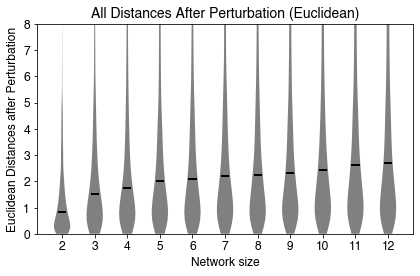

In [ ]:
fig, ax = plt.subplots()

rng = np.random.default_rng()

dists_by_network_size = [list(itertools.chain.from_iterable(np.load(str(pathlib.Path(out_dir,'independent_perturbation',\
                            f'{m}M',f'rmsds_by_function.npy')), allow_pickle=True)))\
                             for m in m_list]

parts = ax.violinplot(positions = m_list,\
           dataset = dists_by_network_size,\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('gray')
    face.set_alpha(1)

parts['cmedians'].set_color('k')
parts['cmedians'].set_linewidth(2)

subsample = 100
size = 2
# for points in dists_by_network_size:
#     if len(points)>subsample:
#         points = rng.choice(points,size=subsample,replace=False)
#     subsample_df = pd.DataFrame({'m':np.full((len(points),),m),'y':points})
#     sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
#         color='k',size=size,alpha=1,edgecolor='none',ax=ax)

_ = ax.set_title('All Distances After Perturbation (RMSD)\n(Independent Perturbation)')
_ = ax.set_xlabel('Network size')
_ = ax.set_xticks(m_list)
_ = ax.set_ylabel(f'RMSD')
_ = ax.set_ylim([0, 8])

filename = f'independent_all_dists_by_network_size_rmsd'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

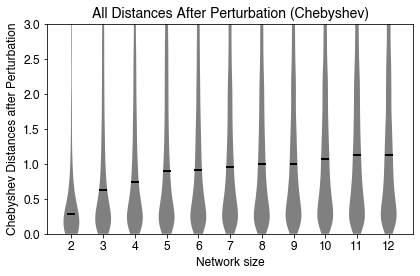

In [ ]:
fig, ax = plt.subplots()
    
rng = np.random.default_rng()

dists_by_network_size = [list(itertools.chain.from_iterable(np.load(str(pathlib.Path(out_dir,'independent_perturbation',\
                            f'{m}M',f'chebyshev_dists_by_function.npy')), allow_pickle=True)))\
                             for m in m_list]

parts = ax.violinplot(positions = m_list,\
           dataset = dists_by_network_size,\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('gray')
    face.set_alpha(1)

parts['cmedians'].set_color('k')
parts['cmedians'].set_linewidth(2)

# for m_i, m in enumerate(m_list):
#     points = dists_by_network_size[m_i]
#     ax.plot([m+rng.uniform(-0.2,0.2) for x in points],points,marker='.',linestyle='',color='k',markersize=6,\
#           markeredgewidth=0,alpha=0.05)

_ = ax.set_title('All Distances After Perturbation (Chebyshev)\n(Independent Perturbation)')
_ = ax.set_xlabel('Network size')
_ = ax.set_xticks(m_list)
_ = ax.set_ylabel(f'Chebyshev Distances after Perturbation')
_ = ax.set_ylim([0, 3])

filename = f'independent_all_dists_by_network_size_chebyshev'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

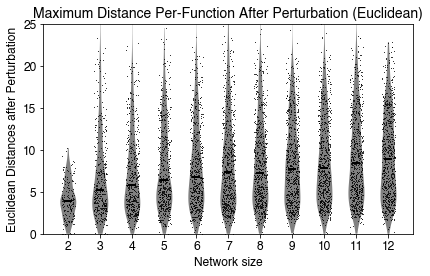

In [ ]:
fig, ax = plt.subplots()

rng = np.random.default_rng()

dists_by_network_size = [np.max(np.load(str(pathlib.Path(out_dir,'independent_perturbation',\
                            f'{m}M',f'rmsds_by_function.npy')), allow_pickle=True),axis=1)\
                             for m in m_list]

parts = ax.violinplot(positions = m_list,\
           dataset = dists_by_network_size,\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('gray')
    face.set_alpha(1)

parts['cmedians'].set_color('k')
parts['cmedians'].set_linewidth(2)

for m_i, m in enumerate(m_list):
    points = dists_by_network_size[m_i]
    ax.plot([m+rng.uniform(-0.2,0.2) for x in points],points,marker='.',linestyle='',color='k',markersize=2,\
          markeredgewidth=0,alpha=1)

_ = ax.set_title('Maximum Distance Per-Function After Perturbation (RMSD)\n(Independent Perturbation)')
_ = ax.set_xlabel('Network size')
_ = ax.set_xticks(m_list)
_ = ax.set_ylabel(f'RMSD')
_ = ax.set_ylim([0, 25])

filename = f'independent_max_dist_by_network_size_RMSD'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

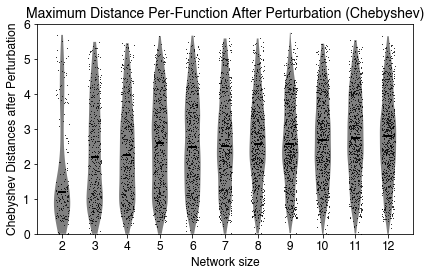

In [ ]:
fig, ax = plt.subplots()

rng = np.random.default_rng()

dists_by_network_size = [np.max(np.load(str(pathlib.Path(out_dir,'independent_perturbation',\
                            f'{m}M',f'chebyshev_dists_by_function.npy')), allow_pickle=True),axis=1)\
                             for m in m_list]

parts = ax.violinplot(positions = m_list,\
           dataset = dists_by_network_size,\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('gray')
    face.set_alpha(1)

parts['cmedians'].set_color('k')
parts['cmedians'].set_linewidth(2)

for m_i, m in enumerate(m_list):
    points = dists_by_network_size[m_i]
    ax.plot([m+rng.uniform(-0.2,0.2) for x in points],points,marker='.',linestyle='',color='k',markersize=2,\
          markeredgewidth=0,alpha=1)

_ = ax.set_title('Maximum Distance Per-Function After Perturbation (Chebyshev)\n(Independent Perturbation)')
_ = ax.set_xlabel('Network size')
_ = ax.set_xticks(m_list)
_ = ax.set_ylabel(f'Chebyshev Distances after Perturbation')
_ = ax.set_ylim([0, 6])

filename = f'independent_max_dist_by_network_size_chebyshev'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Distances: Concerted Noise

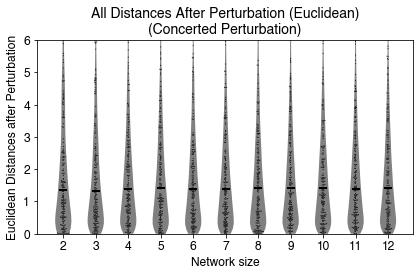

In [ ]:
fig, ax = plt.subplots()

rng = np.random.default_rng()

dists_by_network_size = [list(itertools.chain.from_iterable(np.load(str(pathlib.Path(out_dir,'concerted_perturbation',\
                            f'{m}M',f'rmsds_by_function.npy')), allow_pickle=True)))\
                             for m in m_list]

parts = ax.violinplot(positions = m_list,\
           dataset = dists_by_network_size,\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('gray')
    face.set_alpha(1)

parts['cmedians'].set_color('k')
parts['cmedians'].set_linewidth(2)

subsample = 200
size = 1
for m,points in zip(m_list,dists_by_network_size):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),m),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

_ = ax.set_title('All Distances After Perturbation (RMSD)\n(Concerted Perturbation)')
_ = ax.set_xlabel('Network size')
_ = ax.set_xticks(m_list)
_ = ax.set_ylabel(f'RMSD')
_ = ax.set_ylim([0, 6])

filename = f'concerted_all_dists_by_network_size_RMSD'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

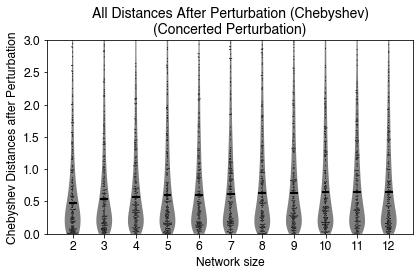

In [ ]:
fig, ax = plt.subplots()
    
rng = np.random.default_rng()

dists_by_network_size = [list(itertools.chain.from_iterable(np.load(str(pathlib.Path(out_dir,'concerted_perturbation',\
                            f'{m}M',f'chebyshev_dists_by_function.npy')), allow_pickle=True)))\
                             for m in m_list]

parts = ax.violinplot(positions = m_list,\
           dataset = dists_by_network_size,\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('gray')
    face.set_alpha(1)

parts['cmedians'].set_color('k')
parts['cmedians'].set_linewidth(2)

subsample = 200
size = 1
for m,points in zip(m_list,dists_by_network_size):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),m),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

_ = ax.set_title('All Distances After Perturbation (Chebyshev)\n(Concerted Perturbation)')
_ = ax.set_xlabel('Network size')
_ = ax.set_xticks(m_list)
_ = ax.set_ylabel(f'Chebyshev Distances after Perturbation')
_ = ax.set_ylim([0, 3])

filename = f'concerted_all_dists_by_network_size_chebyshev'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

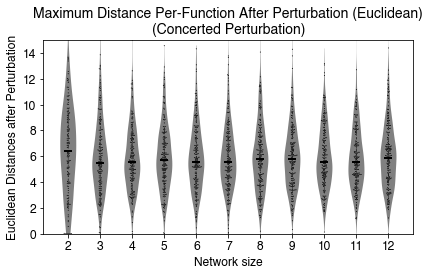

In [ ]:
fig, ax = plt.subplots()

rng = np.random.default_rng()

dists_by_network_size = [np.max(np.load(str(pathlib.Path(out_dir,'concerted_perturbation',\
                            f'{m}M',f'rmsds_by_function.npy')), allow_pickle=True),axis=1)\
                             for m in m_list]

parts = ax.violinplot(positions = m_list,\
           dataset = dists_by_network_size,\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('gray')
    face.set_alpha(1)

parts['cmedians'].set_color('k')
parts['cmedians'].set_linewidth(2)

subsample = 200
size = 1
for m,points in zip(m_list,dists_by_network_size):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),m),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

_ = ax.set_title('Maximum Distance Per-Function After Perturbation (RMSD)\n(Concerted Perturbation)')
_ = ax.set_xlabel('Network size')
_ = ax.set_xticks(m_list)
_ = ax.set_ylabel(f'RMSD')
_ = ax.set_ylim([0, 15])

filename = f'concerted_max_dist_by_network_size_RMSD'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

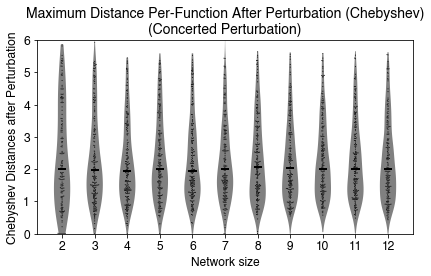

In [ ]:
fig, ax = plt.subplots()

rng = np.random.default_rng()

dists_by_network_size = [np.max(np.load(str(pathlib.Path(out_dir,'concerted_perturbation',\
                            f'{m}M',f'chebyshev_dists_by_function.npy')), allow_pickle=True),axis=1)\
                             for m in m_list]

parts = ax.violinplot(positions = m_list,\
           dataset = dists_by_network_size,\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('gray')
    face.set_alpha(1)

parts['cmedians'].set_color('k')
parts['cmedians'].set_linewidth(2)

subsample = 200
size = 1
for m,points in zip(m_list,dists_by_network_size):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),m),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

_ = ax.set_title('Maximum Distance Per-Function After Perturbation (Chebyshev)\n(Concerted Perturbation)')
_ = ax.set_xlabel('Network size')
_ = ax.set_xticks(m_list)
_ = ax.set_ylabel(f'Chebyshev Distances after Perturbation')
_ = ax.set_ylim([0, 6])

filename = f'concerted_max_dist_by_network_size_chebyshev'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Unique Functions: Independent Noise

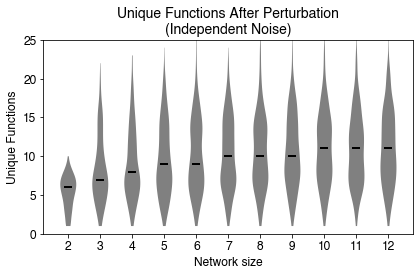

In [ ]:
fig, ax = plt.subplots()

rng = np.random.default_rng()

unique_functions_by_network_size = []

for m in m_list:
    perturbed_voxels_by_original_voxel = np.load(str(pathlib.Path(out_dir,'independent_perturbation',\
                            f'{m}M',f'perturbed_voxels_by_original_voxel.npy')), allow_pickle=True)
    num_voxels_by_original_voxel = [x.shape[0] for x in perturbed_voxels_by_original_voxel]
    unique_functions_by_network_size.append(num_voxels_by_original_voxel)

parts = ax.violinplot(positions = m_list,\
           dataset = unique_functions_by_network_size,\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('gray')
    face.set_alpha(1)

parts['cmedians'].set_color('k')
parts['cmedians'].set_linewidth(2)

_ = ax.set_title('Unique Functions After Perturbation\n(Independent Noise)')
_ = ax.set_xlabel('Network size')
_ = ax.set_xticks(m_list)
_ = ax.set_ylabel(f'Unique Functions')
_ = ax.set_ylim([0,25])

filename = f'independent_voxels_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Unique Functions: Concerted Noise

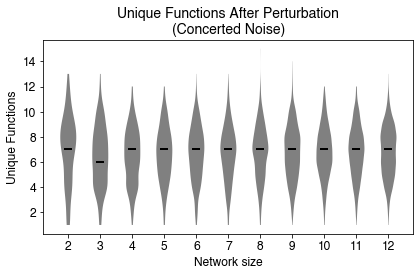

In [ ]:
fig, ax = plt.subplots()

rng = np.random.default_rng()

unique_functions_by_network_size = []

for m in m_list:
    perturbed_voxels_by_original_voxel = np.load(str(pathlib.Path(out_dir,'concerted_perturbation',\
                            f'{m}M',f'perturbed_voxels_by_original_voxel.npy')), allow_pickle=True)
    num_voxels_by_original_voxel = [x.shape[0] for x in perturbed_voxels_by_original_voxel]
    unique_functions_by_network_size.append(num_voxels_by_original_voxel)

parts = ax.violinplot(positions = m_list,\
           dataset = unique_functions_by_network_size,\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('gray')
    face.set_alpha(1)

parts['cmedians'].set_color('k')
parts['cmedians'].set_linewidth(2)



_ = ax.set_title('Unique Functions After Perturbation\n(Concerted Noise)')
_ = ax.set_xlabel('Network size')
_ = ax.set_xticks(m_list)
_ = ax.set_ylabel(f'Unique Functions')
# _ = ax.set_ylim([0,700])

filename = f'concerted_voxels_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Also: Perturbation of Versatile Network Shown in Figure 3B

In [11]:
def simulate_networks(m, num_inputs, param_sets, t = 12, input_lb = -3, input_ub = 3):
    """
    Run simulations for dimer networks, over a titration of concentrations for each input monomer. 
    When >1 input monomers are varied (e.g., a 2D matrix), the first monomer is sampled outermost, 
    while the second is sampled inner to that.
    
    Parameters
    ----------
    m : int. 
        Number of monomer species in the network.
    num_inputs: int
        Number of monomers to count as inputs (those titrated). 
        E.g., if num_inputs=2, the first two monomers will be treated as inputs.
    t : int. Default 12. 
        Number of values to titrate each input monomer species. 
        Values spaced evenly on a log10 scale
    input_lb : int. Default -3
        lower bound for titrating the input monomer species. Log10 scale
    input_ub : int. Default 3
        upper bound for titrating the input monomer species.Llog10 scale
    param_sets : Array-like, shape (num_sets, num_parameters)
        Parameter sets for simulating multiple dimerization networks.  
    Returns
    -------
    C0 : Array-like, shape (t, number of species)
        Initial concentration array used for eqtk.solve
    S_all : Array-like, shape (t, number of species, num_sets) 
        Equlibrium concentration of all species
        for all parameter sets and each input titration point.
        
    """
    # Create stoichiometry matrix 
    num_sets = param_sets.shape[0]
    N = make_nXn_stoich_matrix(m)
    num_rxns = N.shape[0]

    # Create initial concentration array
    M0_min = [input_lb]*num_inputs + [0] * (m-num_inputs) # Species concentrations at min of inputs
    M0_max = [input_ub]*num_inputs + [0] * (m-num_inputs) # Species concentrations at max of inputs
    num_conc = [t]*num_inputs + [1] * (m-num_inputs) # Number of concentrations to titrate for each species
    C0 = make_C0_grid(m, M0_min=M0_min, M0_max=M0_max, num_conc=num_conc) 
        
    acc_monomer_ind = np.arange(num_inputs,m) # Indices of accessory monomers
    S_all = np.zeros((C0.shape[0], C0.shape[1], num_sets))
    # For each parameter set, run eqtk.solve
    for pset_index, pset in enumerate(param_sets):
        S_all[:,:,pset_index] = run_eqtk(N, C0.copy(), pset, acc_monomer_ind)
    return C0,S_all  
                

In [18]:
m = 3
num_inputs = 1
input_lb = -3 # Lower bound for log10 of input concentrations
input_ub = 3 # Upper bound for log10 of input concentrations
t = 30 # Number of input concentrations to simulate

In [13]:
param_sets_versatile = {
    'stepdown': np.array([7.58874082e-01, 3.60550393e+03, 3.59318162e+01, 5.46408949e-03,
        8.70172144e+03, 1.05351010e+00, 1.00000000e-01, 1.34942191e+00]),
    'stepup': np.array([7.58874082e-01, 3.60550393e+03, 3.59318162e+01, 5.46408949e-03,
        8.70172144e+03, 1.05351010e+00, 2.62756786e+02, 2.61698411e+02]),
}

dimer_of_interest = make_nXn_species_names(m).index('D_3_3') - m # Index of dimer to use as output (D_1_1 = index 0)


In [14]:
meta_name = 'stepup-stepdown-versatile'
names_to_plot = list(param_sets_versatile.keys())

In [15]:
rng = np.random.default_rng()

num_A_sets = 50

# Gamma distribution parameters
independent_noise = 0.4

independent_shape = 1/(independent_noise**2)
independent_scale = independent_noise**2

Now re-run the analysis but just for this function

In [24]:
original_param_set = param_sets_versatile['stepdown']

perturbed_param_sets_Fig3Bversatile = np.repeat(np.expand_dims(original_param_set,axis=0),num_A_sets,axis=0)
# Multiply the original accessory expression vals by randomly chosen factors
perturbed_param_sets_Fig3Bversatile[1:,-(m-num_inputs):] = np.multiply(original_param_set[-(m-num_inputs):],\
                                                                    rng.gamma(shape=independent_shape,scale=independent_scale,size=(num_A_sets-1,m-num_inputs)))

np.save(str(pathlib.Path(out_dir,f'perturbed_param_sets_Fig3Bversatile.npy')), perturbed_param_sets_Fig3Bversatile)

In [ ]:
# Simulate

_, S_all = simulate_networks(m = m, num_inputs = num_inputs, t = t, param_sets=perturbed_param_sets_Fig3Bversatile, input_lb = input_lb, \
                            input_ub = input_ub)

In [26]:
# We only care about the responses from our dimers of interest - so we'll extract those responses
dimers_per_param_set = num_combos_with_replacement(m,2)
perturbed_responses_Fig3Bversatile = S_all[:,m+dimer_of_interest,:].reshape((t,-1),order='F').T # Get dimer of interest and reshape

# Round concentrations that are too small to be relevant
perturbed_responses_Fig3Bversatile[np.where(perturbed_responses_Fig3Bversatile<10**input_lb)] = 10**input_lb
np.save(str(pathlib.Path(out_dir,f'perturbed_responses_Fig3Bversatile.npy')), perturbed_responses_Fig3Bversatile)

# For each unique function we perturbed, we will calculate curve distances from the original in log space
original = np.log10(perturbed_responses_Fig3Bversatile[0])
all_perturbed = np.log10(perturbed_responses_Fig3Bversatile[1:])
rmsds_Fig3Bversatile = [calculate_RMSD(original,perturbed) for perturbed in all_perturbed]

np.save(str(pathlib.Path(out_dir,f'rmsds_Fig3Bversatile.npy')), rmsds_Fig3Bversatile)

In [52]:
median_rmsd = np.median(rmsds_Fig3Bversatile)

print('Median RMSD: {}'.format(round(median_rmsd,2)))

Median RMSD: 0.18


### Plot the results

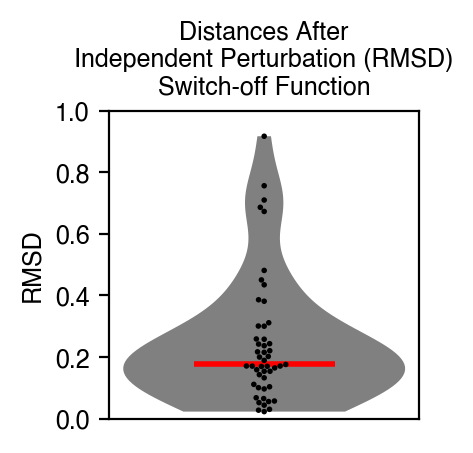

In [46]:
fig, ax = plt.subplots(figsize=(2,2))

rng = np.random.default_rng()

parts = ax.violinplot(positions = [0],\
        dataset = [rmsds_Fig3Bversatile],\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('gray')
    face.set_alpha(1)

parts['cmedians'].set_color('r')
parts['cmedians'].set_linewidth(2)

subsample = 50
size = 2
for i,points in enumerate([rmsds_Fig3Bversatile]):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),i),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

_ = ax.set_title('Distances After\nIndependent Perturbation (RMSD)\nSwitch-off Function')
_ = ax.set_ylabel(f'RMSD')
_ = ax.set_ylim([0,1])

ax.set_xticks([])
ax.set_xlabel('')

fig.set_dpi(200)

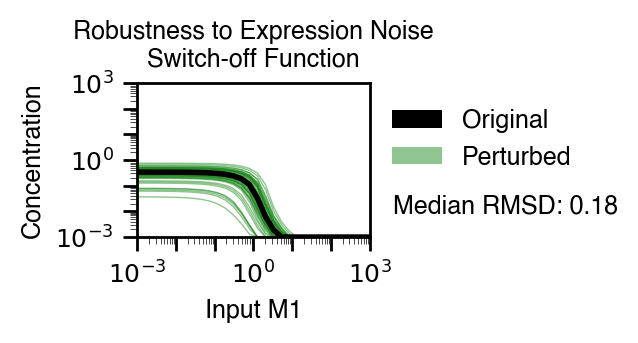

In [73]:
save = True

fig, ax = plt.subplots(figsize=(1.5,1))

x_points = list(10**np.linspace(input_lb,input_ub,t,endpoint=True))

for param_set_i in range(1,num_A_sets):
    ax.plot(x_points,perturbed_responses_Fig3Bversatile[param_set_i],marker=None,linestyle='-',color='forestgreen',\
                        alpha=0.5,lw=0.5)
    
# Plot original
ax.plot(x_points,perturbed_responses_Fig3Bversatile[0],marker=None,linestyle='-',color='k',\
                        alpha=1,lw=2)


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([10**input_lb,10**input_ub])
ax.set_ylim([10**-3,10**3])

ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

# Set ticks
set_simple_log_ticks(ax,which='x',log_lowerbound=-3,log_upperbound=3,max_labels=4)
set_simple_log_ticks(ax,which='y',log_lowerbound=-3,log_upperbound=3,max_labels=4)

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks

_ = ax.set_xlabel('Input M1')
_ = ax.set_ylabel('Concentration')
_ = ax.set_title('Robustness to Expression Noise\nSwitch-off Function')

patches={}
patches[f'original'] = mpatches.Patch(facecolor='k',linewidth=0,linestyle='',\
                                            alpha=1,label=f'Original',edgecolor=None)
patches[f'perturbed'] = mpatches.Patch(facecolor='forestgreen',linewidth=0,linestyle='',\
                                            alpha=0.5,label=f'Perturbed',edgecolor=None)

leg = fig.legend(bbox_to_anchor=(0.9, 0.6), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

# Label RMSD
_ = ax.text(1.1, 0.2, f'Median RMSD: {round(median_rmsd,2)}', horizontalalignment='left', verticalalignment='center',\
            transform=ax.transAxes,fontsize=9)

fig.set_dpi(200)

if save:
    filename = f'FigS5F_{meta_name}_perturbed_responses'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')